In [1]:
#import libraries
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# For cleaning data
!pip install tweet-preprocessor
import preprocessor as p

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [7]:
# train_data =  pd.read_csv('/content/train.csv')
#test_data =  pd.read_csv('/content/test.csv')
test_data = pd.read_csv('data/nlp-getting-started/test.csv')
train_data = pd.read_csv('data/nlp-getting-started/train.csv')

features:

- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [8]:
# Shape of data
print(train_data.shape[0], train_data.shape[1])

7613 5


In [9]:
# Thoughts on breaking down hashtags and tags into their own features? Might be useful
# Found this article that does it: https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e
train_data['hashtags'] = train_data['text'].apply(lambda s: re.findall(r'#(\w+)', s))
test_data['hashtags'] = train_data['text'].apply(lambda s: re.findall(r'#(\w+)', s))

train_data['mentions'] = train_data['text'].apply(lambda x: re.findall(r"@(\w+)", x))
test_data['mentions'] = train_data['text'].apply(lambda x: re.findall(r"@(\w+)", x))

# The data has all links replaced with links that start with "t.co", for example http://t.co/lHYXEOHY6C
# See https://help.twitter.com/en/using-twitter/url-shortener
train_data['links'] = train_data['text'].apply(lambda x: re.findall(r"(https?:\/\/t.co/\w+)", x))
test_data['links'] = train_data['text'].apply(lambda x: re.findall(r"(https?:\/\/t.co/\w+)", x))

train_data['is_retweet'] = train_data['text'].apply(lambda x: "rt" in x.lower().split())
test_data['is_retweet'] = train_data['text'].apply(lambda x: "rt" in x.lower().split())

train_data['has_mentions'] = train_data.mentions.apply(lambda y: 0 if len(y)==0 else 1)
test_data['has_mentions'] = test_data.mentions.apply(lambda y: 0 if len(y)==0 else 1)

train_data['has_hashtags'] = train_data.hashtags.apply(lambda y: 0 if len(y)==0 else 1)
test_data['has_hashtags'] = test_data.hashtags.apply(lambda y: 0 if len(y)==0 else 1)

train_data['has_links'] = train_data.links.apply(lambda y: 0 if len(y)==0 else 1)
test_data['has_links'] = test_data.links.apply(lambda y: 0 if len(y)==0 else 1)

train_data['mention_count'] = train_data.mentions.apply(lambda y: len(y))
test_data['mention_count'] = test_data.mentions.apply(lambda y: len(y))
train_data['hashtag_count'] = train_data.hashtags.apply(lambda y: len(y))
test_data['hashtag_count'] = test_data.hashtags.apply(lambda y: len(y))

train_data['link_count'] = train_data.links.apply(lambda y: len(y))
test_data['link_count'] = test_data.links.apply(lambda y: len(y))

# print(train_data[train_data.hashtag.astype(bool)])
# print(train_data[train_data.mentions.astype(bool)])

# Replace empty list with NANs


train_data

# for i,v in enumerate(train_data['text']):
#   train_data.loc[i,'text'] = p.clean(v)

# for i,v in enumerate(test_data['text']):
#   test_data.loc[i,'text'] = p.clean(v)

# dev_data = train_data[5000:]
# train_data = train_data[:5000]

# TODO: Actually break these sets down into shuffled sets + labels

,id,keyword,location,text,target,hashtags,mentions,links,is_retweet,has_mentions,has_hashtags,has_links,mention_count,hashtag_count,link_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],[],[],False,0,1,0,0,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],[],[],False,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],[],[],False,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],[],[],False,0,1,0,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[Alaska, wildfires]",[],[],False,0,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,[],[],[http://t.co/STfMbbZFB5],False,0,0,1,0,0,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,[],"[aria_ahrary, TheTawniest]",[],False,1,0,0,2,0,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,[],[],[http://t.co/zDtoyd8EbJ],False,0,0,1,0,0,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,[],[],[],False,0,0,0,0,0,0


In [10]:
def is_empty_list(list):
    return list == []

# Head of data
print(train_data.head(5))
# NANs
print(train_data.isna().sum())
# It looks like location is an optional field, same with keyword

print("Number of tweets with hashtags: ", train_data.has_hashtags.sum())
print("Number of tweets with mentions: ", train_data.has_mentions.sum())
print("Number of tweets with links: ", train_data.has_links.sum())
print("Number of tweets that are retweets: ", train_data.is_retweet.sum())

print("Percentage of tweets with hashtags: ", train_data.has_hashtags.sum()/train_data.shape[0])
print("Percentage of tweets with mentions: ", train_data.has_mentions.sum()/train_data.shape[0])
print("Percentage of tweets with links: ", train_data.has_links.sum()/train_data.shape[0])
print("Percentage of tweets that are retweets: ", train_data.is_retweet.sum()/train_data.shape[0])

print("Total number of hashtags in all training tweets: ", train_data.hashtag_count.sum())
print("Total number of mentions in all training tweets: ", train_data.mention_count.sum())
print("Total number of links in all training tweets: ", train_data.link_count.sum())

print("Average number of hashtags in all training tweets: ", train_data.hashtag_count.sum()/train_data.shape[0])
print("Average number of mentions in all training tweets: ", train_data.mention_count.sum()/train_data.shape[0])
print("Average number of links in all training tweets: ", train_data.link_count.sum()/train_data.shape[0])

print("Average number of hashtags for training tweets that do have hashtags: ", train_data.hashtag_count.sum()/train_data.has_hashtags.sum())
print("Average number of mentions for training tweets that do have mentions: ", train_data.mention_count.sum()/train_data.has_mentions.sum())
print("Average number of links for training tweets that do have links: ", train_data.link_count.sum()/train_data.has_links.sum())

disaster_train_data = train_data[train_data.target == 1]
nondisaster_train_data = train_data[train_data.target == 0]

print("Number of disaster tweets: ", disaster_train_data.shape[0])
print("Number of non-disaster tweets: ", nondisaster_train_data.shape[0])

print("Average number of hashtags for disaster tweets: ", disaster_train_data.hashtag_count.sum()/disaster_train_data.shape[0])
print("Average number of hashtags for non-disaster tweets: ", nondisaster_train_data.hashtag_count.sum()/nondisaster_train_data.shape[0])

print("Average number of mentions for disaster tweets: ", disaster_train_data.mention_count.sum()/disaster_train_data.shape[0])
print("Average number of mentions for non-disaster tweets: ", nondisaster_train_data.mention_count.sum()/nondisaster_train_data.shape[0])

print("Average number of links for disaster tweets: ", disaster_train_data.link_count.sum()/disaster_train_data.shape[0])
print("Average number of links for non-disaster tweets: ", nondisaster_train_data.link_count.sum()/nondisaster_train_data.shape[0])

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target             hashtags mentions links  is_retweet  has_mentions  \
0       1         [earthquake]       []    []       False             0   
1       1                   []       []    []       False             0   
2       1                   []       []    []       False             0   
3       1          [wildfires]       []    []       False             0   
4       1  [Alaska, wildfires]       []    []       False             0   

   has_hashtags  has_links  mention_count  hashtag_count  link_count  
0             1

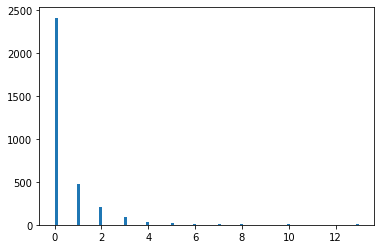

In [11]:
plt.hist(disaster_train_data.hashtag_count, bins='auto')
plt.title="Hashtag Count Distribution for Disaster Training Data"
plt.show()

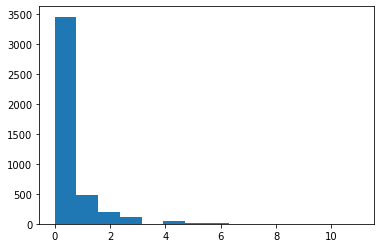

In [12]:
plt.hist(nondisaster_train_data.hashtag_count, bins='auto')
plt.title="Hashtag Count Distribution for Non-Disaster Training Data"
plt.show()

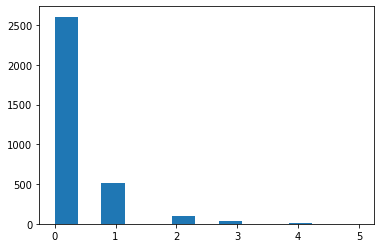

In [13]:
plt.hist(disaster_train_data.mention_count, bins='auto')
plt.title="Mention Count Distribution for Disaster Training Data"
plt.show()

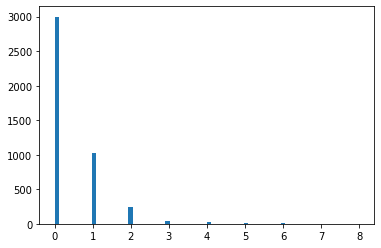

In [ ]:
plt.hist(nondisaster_train_data.mention_count, bins='auto')
plt.title="Mention Count Distribution for Non-Disaster Training Data"
plt.show()

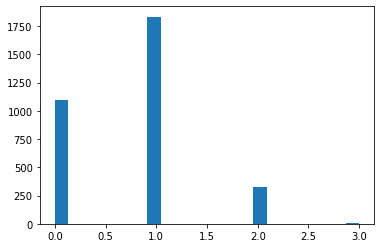

In [ ]:
plt.hist(disaster_train_data.link_count, bins='auto')
plt.title="Link Count Distribution for Disaster Training Data"
plt.show()

# Disaster tweets have more links than non-disaster tweets, this is promising

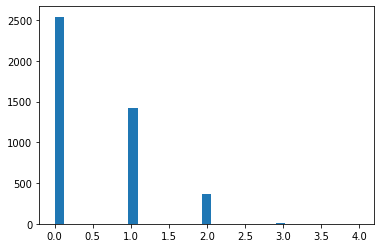

In [ ]:
plt.hist(nondisaster_train_data.link_count, bins='auto')
plt.title="Link Count Distribution for Non-Disaster Training Data"
plt.show()

In [ ]:
# Verifying that all links look good, can remove
train_data.links.tolist()

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['http://t.co/lHYXEOHY6C'],
 ['http://t.co/YAo1e0xngw'],
 ['http://t.co/2nndBGwyEi'],
 [],
 ['http://t.co/qqsmshaJ3N'],
 [],
 ['http://t.co/3ImaomknnA'],
 ['http://t.co/wDUEaj8Q4J'],
 [],
 ['http://t.co/rOI2NSmEJJ',
  'http://t.co/3Tj8ZjiN21',
  'http://t.co/YDUiXEfIpE',
  'http://t.co/LxTjc87KLS'],
 [],
 [],
 [],
 ['http://t.co/o9qknbfOFX'],
 ['http://t.co/TIyUliF5c6'],
 ['http://t.co/vl5TBR3wbr'],
 [],
 ['http://t.co/rOI2NSmEJJ',
  'http://t.co/3Tj8ZjiN21',
  'http://t.co/YDUiXEfIpE',
  'http://t.co/LxTjc87KLS'],
 [],
 ['http://t.co/gWNRhMSO8k'],
 ['http://t.co/eV1ahOUCZA'],
 ['http://t.co/vplR5Hka2u', 'http://t.co/SxHW2TNNLf'],
 ['http://t.co/pcXarbH9An'],
 ['http://t.co/uc4j4jHvGR'],
 ['http://t.co/4IzFdYC3cg'],
 ['http://t.co/8kscqKfKkF'],
 ['https://t.co/cYoMPZ1A0Z'],
 [],
 ['http://t.co/iCSjGZ9tE1', 'http://t.co/9FxmN0l0Bd'],

In [ ]:
# Get all the disaster tweets top keywords
print(train_data[train_data.target == 1].groupby(['keyword']).count().sort_values('id', ascending=False)['id'])
# Get all the non-disaster tweets top keyword
print(train_data[train_data.target == 0].groupby(['keyword']).count().sort_values('id', ascending=False)['id'])

# print(train_data[train_data.target == 0].groupby(['keyword']).size().reset_index(name='counts').sort_values('counts', ascending=False))

keyword
derailment     39
wreckage       39
outbreak       39
debris         37
oil%20spill    37
               ..
blazing         1
epicentre       1
body%20bag      1
electrocute     1
ruin            1
Name: id, Length: 220, dtype: int64
keyword
body%20bags          40
harm                 37
armageddon           37
wrecked              36
ruin                 36
                     ..
typhoon               1
suicide%20bombing     1
suicide%20bomber      1
outbreak              1
oil%20spill           1
Name: id, Length: 218, dtype: int64


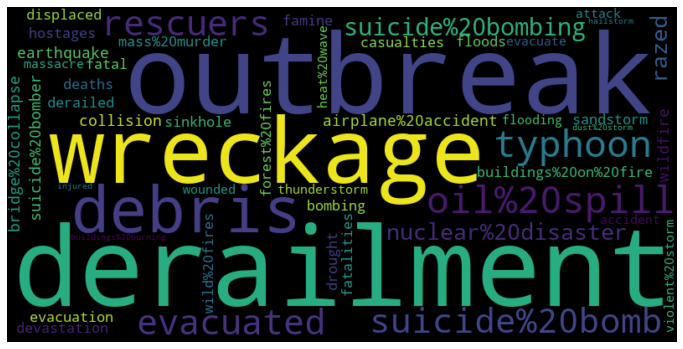

In [ ]:
# Shows that keywords are not hashtags
# 0 & train_data.keyword.str.contains("body%20bags")]

from wordcloud import WordCloud
from nltk import word_tokenize, sent_tokenize, FreqDist
#Frequency of words
fdist_0 = FreqDist(train_data[train_data.target == 0]['keyword'])
fdist_1 = FreqDist(train_data[train_data.target == 1 & train_data.keyword.notna()]['keyword'])

#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_1)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
train_data.groupby(['keyword']).count().sort_values('id', ascending=False)['id'].to_string()

'keyword\nfatalities               45\ndeluge                   42\narmageddon               42\nsinking                  41\ndamage                   41\nharm                     41\nbody%20bags              41\noutbreak                 40\nevacuate                 40\nfear                     40\ncollided                 40\nsiren                    40\ntwister                  40\nwindstorm                40\nsinkhole                 39\nsunk                     39\nhellfire                 39\nweapon                   39\nweapons                  39\nfamine                   39\nexplosion                39\nwhirlwind                39\nearthquake               39\nderailment               39\nwreckage                 39\ncollision                39\nflames                   39\nwrecked                  39\noil%20spill              38\nflooding                 38\ndeaths                   38\nderailed                 38\nthunder                  38\nambulance                38\ndrow

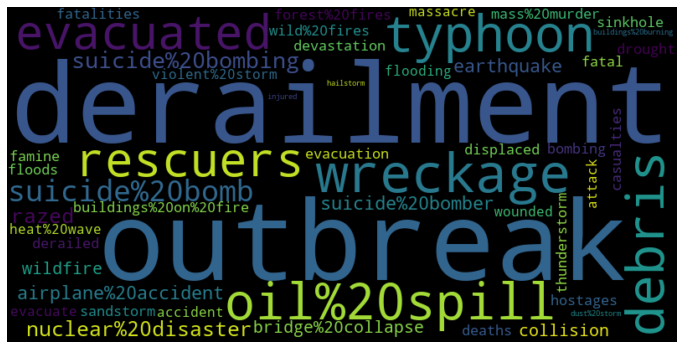

In [ ]:
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_1)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()